In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Laplace's equation

$$ \nabla ^2 V (x, y, z) = \frac{\partial^2V}{\partial x^2}+\frac{\partial^2V}{\partial y^2}+\frac{\partial^2V}{\partial z^2} = 0$$

See Figure 10.1

In [2]:
def SOR(N=11, w=1.54, maxError=1e-6):

    # setup
    isConductor = np.zeros((N, N), dtype=bool)
    V = np.zeros((N, N), dtype=float)

    isConductor[0, :] = True
    V[0, :] = 10
    isConductor[-1, :] = True
    V[-1, :] = 10
    isConductor[:, 0] = True
    V[:, 0] = 5
    isConductor[:, -1] = True
    V[:, -1] = 5
    
    V[0, 0] = V[0, -1] = np.nan
    V[-1, 0] = V[-1, -1] = np.nan
    step = 0
    
    rows = []
    while True:
        # relax
        error = 0
        for i in range(1, N-1):
            for j in range(1, N-1):
                if not isConductor[i, j]:
                    v = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1])/4
                    dv = V[i, j] - v
                    error = max(error, abs(dv))
                    V[i, j] = w * v + (1 - w)*V[i, j]
        step += 1
        
        rows.append({'step': step, 'error': error})
        
        if error < maxError:
            break
    
    return { 'errors': pd.DataFrame(rows),
             'soln': V}      

In [3]:
rows = []
maxError = 1e-4

for w in np.arange(1, 1.95, 0.01):
    
    N = 11
    row = {'w': w}
    
    results = SOR(w=w, N=N, maxError=maxError)
    SOR_steps = len(results['errors'])

    row[f'steps'] = SOR_steps 
        
    rows.append(row)
                
df = pd.DataFrame(rows)

In [4]:
idx = df.steps.idxmin()
df.iloc[idx]      

w         1.54
steps    23.00
Name: 54, dtype: float64

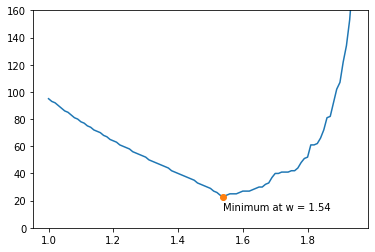

In [5]:
plt.plot(df.w, df.steps)
idx = df.steps.idxmin()
w, steps = df.iloc[idx]
plt.plot(w, steps, 'o')
plt.text(w, steps-10, f'Minimum at w = {w:.2f}')
plt.ylim(0, 160)
plt.show()

In [6]:
results = SOR(N=11, w=1.54, maxError=1e-14)
V = results['soln']

In [7]:
results['errors']

,step,error
0,1,6.216574e+00
1,2,4.030814e+00
2,3,2.627112e+00
3,4,1.672393e+00
4,5,9.868590e-01
...,...,...
57,58,1.874056e-13
58,59,7.194245e-14
59,60,1.332268e-14
60,61,1.154632e-14


In [8]:
Y, X = np.mgrid[0:N, 0:N]
Yedge, Xedge = np.mgrid[-0.5:N+0.5, -0.5:N+0.5]

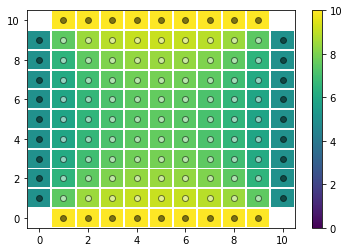

In [9]:
plt.pcolormesh(Xedge, Yedge, V, 
               edgecolor='w', vmin=0, vmax=10)
plt.colorbar()

plt.scatter(X[1:-1, 1:-1], Y[1:-1, 1:-1], 
            edgecolor='k', color='w', alpha=0.5)

for i in [ (0, slice(1, -1)),
           (-1, slice(1, -1)),
           (slice(1, -1), 0),
           (slice(1, -1), -1)]:
    plt.scatter(X[i], Y[i],  color='k', alpha=0.5)


plt.show()

In [10]:
V[5,5]

7.500000000000001

In [11]:
V_SOR = V

## 10.6 Random Walk Solution of Laplace's Equation

$$ V(x, y) = \frac{1}{4} \sum_{i=1}^4 V(i)$$

This can also be interpreted probalistically by considering random walkers.

See algorithm in section 10.6

In [12]:
def randomWalkSolver():
    
    N = 11
    
    # setup
    isConductor = np.zeros((N, N), dtype=bool)
    V = np.zeros((N, N), dtype=float)

    isConductor[0, :] = True
    V[0, :] = 10
    isConductor[-1, :] = True
    V[-1, :] = 10
    isConductor[:, 0] = True
    V[:, 0] = 5
    isConductor[:, -1] = True
    V[:, -1] = 5
    
    V[0, 0] = V[0, -1] = np.nan
    V[-1, 0] = V[-1, -1] = np.nan
    V[1:N-1, 1:N-1] = np.nan
    
    step = 0
    directions = [(0,1), (0,-1), (1,0), (-1,0)]
    
    for x0 in range(1,N-1,2):
        for y0 in range(1, N-1, 2):

            n = 1000

            Vsum = 0
            for k in range(n):
                x = x0
                y = y0
                while not isConductor[x, y]:
                    i = np.random.randint(4)
                    dx, dy = directions[i]
                    x += dx
                    y += dy

                Vsum += V[x, y]

            V[x0, y0] = Vsum/n
            
    return V
        

In [13]:
V_RW = randomWalkSolver()

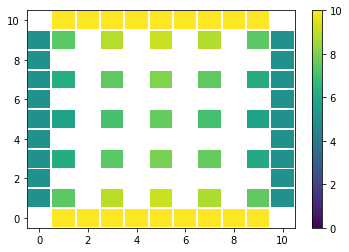

In [14]:
plt.pcolormesh(Xedge, Yedge, V_RW, 
               edgecolor='w', vmin=0, vmax=10)
plt.colorbar()

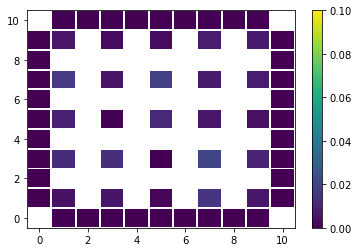

In [15]:
plt.pcolormesh(Xedge, Yedge, abs(V_RW - V_SOR)/V_SOR, 
               edgecolor='w', vmin=0, vmax=0.10)
plt.colorbar()

In [16]:
from numba import jit

In [17]:
@jit
def randomWalkSolver():
    
    N = 11
    
    # setup
    isConductor = np.zeros((N, N), dtype=np.bool8)
    V = np.zeros((N, N))

    isConductor[0, :] = True
    V[0, :] = 10
    isConductor[-1, :] = True
    V[-1, :] = 10
    isConductor[:, 0] = True
    V[:, 0] = 5
    isConductor[:, -1] = True
    V[:, -1] = 5
    
    V[0, 0] = V[0, -1] = np.nan
    V[-1, 0] = V[-1, -1] = np.nan
    V[1:N-1, 1:N-1] = np.nan
    
    num_walkers = np.zeros((N, N))*np.nan
    
    step = 0
    directions = [(0,1), (0,-1), (1,0), (-1,0)]
    
    for x0 in range(1,N-1):
        for y0 in range(1,N-1):
            V[x0, y0] = 0 # initial guess

            n = 0

            Vsum = 0
            Vsum_sqr = 0
            while True:
                x = x0
                y = y0
                while not isConductor[x, y]:
                    i = np.random.randint(4)
                    dx, dy = directions[i]
                    x += dx
                    y += dy
                
                n += 1
                Vsum += V[x, y]
                Vsum_sqr += V[x, y]**2
                
                if n > 5:
                    σ = np.sqrt((Vsum_sqr - (Vsum**2)/n)/(n-1))
                    ##print(f"{n}, {Vsum/n:.2f}, {σ/np.sqrt(n):.3f}")
                    if σ/np.sqrt(n) < 0.01:
                        break

            V[x0, y0] = Vsum/n
            num_walkers[x0, y0] = n
            
    return V, num_walkers

In [20]:
%%time
V_RW, num_walkers = randomWalkSolver()

CPU times: user 546 ms, sys: 6 ms, total: 552 ms
Wall time: 685 ms


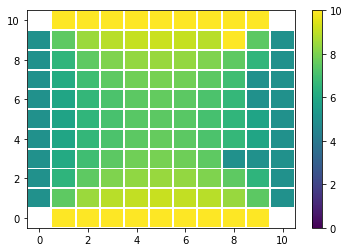

In [483]:
plt.pcolormesh(Xedge, Yedge, V_RW, 
               edgecolor='w', vmin=0, vmax=10)
plt.colorbar()

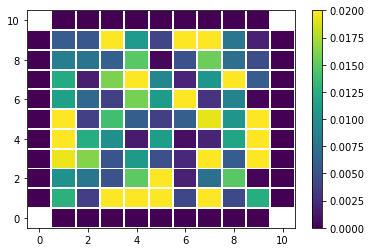

In [21]:
plt.pcolormesh(Xedge, Yedge, abs(V_RW - V_SOR), 
               edgecolor='w', vmin=0, vmax=0.02)
plt.colorbar()

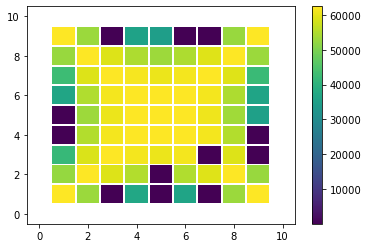

In [22]:
plt.pcolormesh(Xedge, Yedge, num_walkers,
               edgecolor='w')
plt.colorbar()